In [33]:
import sys

sys.path.append('../../notebooks')
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import constants
import model_utils

In [34]:
df = pd.read_json('data/translated/emotions/emotions_dataset_pl.json')
df

,text,emotions,text_pl
0,i feel awful about it too because it s my job ...,sadness,"Też czuję się z tym okropnie, bo moim zadaniem..."
1,im alone i feel awful,sadness,Jestem sama czuję się okropnie
2,ive probably mentioned this before but i reall...,joy,"Prawdopodobnie wspomniałem o tym wcześniej, al..."
3,i was feeling a little low few days back,sadness,Czułem się trochę nisko kilka dni temu
4,i beleive that i am much more sensitive to oth...,love,"Wyobrażam sobie, że jestem znacznie bardziej w..."
...,...,...,...
39995,i witness what i feel helpless to change i tak...,sadness,"Jestem świadkiem tego, co czuję się bezradny z..."
39996,i feel unwelcome and i feel very self consciou...,sadness,Czuję się niemile widziany i czuję się bardzo ...
39997,i feel like boston is so romantic when its rai...,love,"Czuję, że Boston jest taki romantyczny, kiedy ..."
39998,i thought sure i was coming down with somethin...,joy,"Myślałem, że z czymś zejdę, ale dziś rano czuj..."


In [35]:
df = df.drop(columns=['text'])
df

,emotions,text_pl
0,sadness,"Też czuję się z tym okropnie, bo moim zadaniem..."
1,sadness,Jestem sama czuję się okropnie
2,joy,"Prawdopodobnie wspomniałem o tym wcześniej, al..."
3,sadness,Czułem się trochę nisko kilka dni temu
4,love,"Wyobrażam sobie, że jestem znacznie bardziej w..."
...,...,...
39995,sadness,"Jestem świadkiem tego, co czuję się bezradny z..."
39996,sadness,Czuję się niemile widziany i czuję się bardzo ...
39997,love,"Czuję, że Boston jest taki romantyczny, kiedy ..."
39998,joy,"Myślałem, że z czymś zejdę, ale dziś rano czuj..."


In [39]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.
df = df.iloc[:40000]
df

,emotions,text_pl
0,sadness,"Też czuję się z tym okropnie, bo moim zadaniem..."
1,sadness,Jestem sama czuję się okropnie
2,joy,"Prawdopodobnie wspomniałem o tym wcześniej, al..."
3,sadness,Czułem się trochę nisko kilka dni temu
4,love,"Wyobrażam sobie, że jestem znacznie bardziej w..."
...,...,...
39995,sadness,"Jestem świadkiem tego, co czuję się bezradny z..."
39996,sadness,Czuję się niemile widziany i czuję się bardzo ...
39997,love,"Czuję, że Boston jest taki romantyczny, kiedy ..."
39998,joy,"Myślałem, że z czymś zejdę, ale dziś rano czuj..."


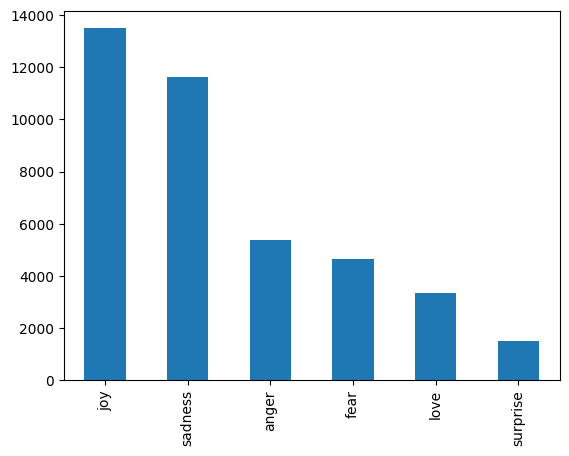

In [40]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [41]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [42]:
df = df.replace({"emotions": ordered_class_labels})

In [ ]:
!pip install datasets
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

In [ ]:
!pip install transformers
from transformers import AutoTokenizer

checkpoint = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [45]:
def tokenize_function(example):
    return tokenizer(example["text_pl"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [46]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5)

In [47]:
from transformers import DataCollatorWithPadding

columns = ["attention_mask", "input_ids", "token_type_ids"]
label_cols = ["emotions"]
batch_size = 8
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [48]:
# Model parameters
training_number = 2
model_name = "emotions_pl_bert"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = f"documentation/models/emotions_pl_bert/figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [49]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [50]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [51]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [53]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
4000/4000 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.8046
Epoch 1: saving model to training_checkpoints/emotions_pl_bert/training_2/cp-0001.ckpt
4000/4000 [==============================] - 626s 142ms/step - loss: 0.5450 - accuracy: 0.8046 - val_loss: 0.3800 - val_accuracy: 0.8475
Epoch 2/10
4000/4000 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.8752
Epoch 2: saving model to training_checkpoints/emotions_pl_bert/training_2/cp-0002.ckpt
4000/4000 [==============================] - 522s 130ms/step - loss: 0.3181 - accuracy: 0.8752 - val_loss: 0.4071 - val_accuracy: 0.8560
Epoch 3/10
4000/4000 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9043
Epoch 3: saving model to training_checkpoints/emotions_pl_bert/training_2/cp-0003.ckpt
4000/4000 [==============================] - 531s 133ms/step - loss: 0.2332 - accuracy: 0.9043 - val_loss: 0.4290 - val_accuracy: 0.8545
Epoch 4/10
4000/4000 [============

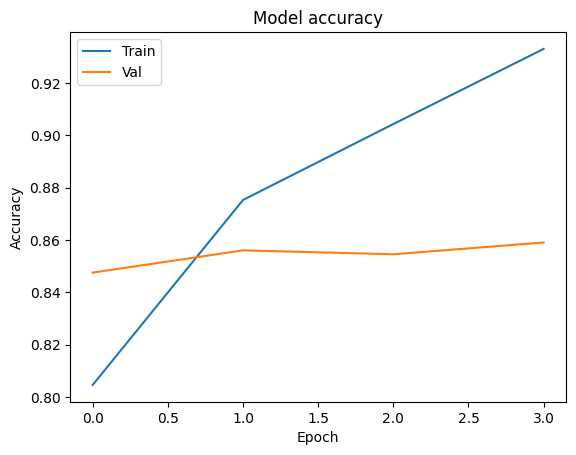

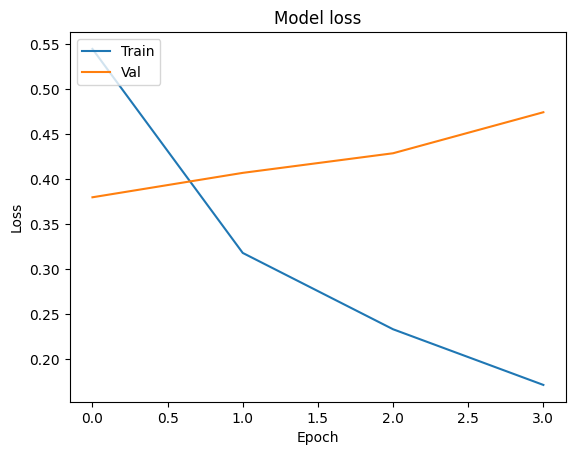

In [54]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [55]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [56]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

In [57]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

500/500 [==============================] - 24s 48ms/step - loss: 0.4046 - accuracy: 0.8487


[0.4045797288417816, 0.8487499952316284]

In [58]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

500/500 [==============================] - 28s 49ms/step


In [59]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics_for_emotions(
    class_actual=tokenized_test_dataset['emotions'],
    class_preds=class_preds)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.84875
Recall score:  0.84875
F1 score:  0.84875


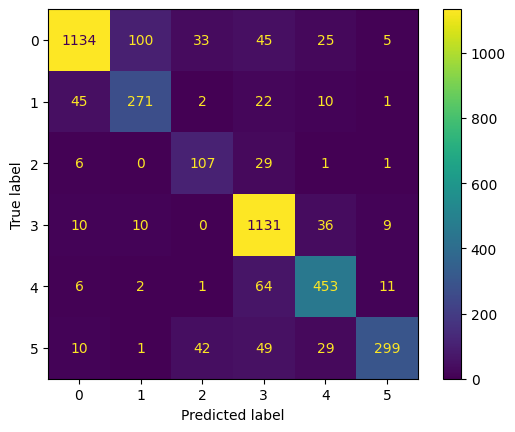

In [60]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [61]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['text_pl'],
                                              class_actual=raw_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: Jestem sama czuję się okropnie
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 3
            

            BAD PREDICTION:
            - INDEX: 2
            - TEXT: Prawdopodobnie wspomniałem o tym wcześniej, ale naprawdę czuję się dumny z siebie, że faktycznie dotrzymuję kroku mojemu noworocznemu postanowieniu miesięcznych i tygodniowych celów.
            - PREDICTED VALUE: 3
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: Wyobrażam sobie, że jestem znacznie bardziej wrażliwy na uczucia innych ludzi i wydaję się być bardziej współczujący.
            - PREDICTED VALUE: 4
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 5
            - TEXT: Jestem sfrustrowany chrześcijanami, ponieważ czuję, że ciągle mówi się o kochaniu siebie nawzajem, o byciu tam dla siebie i modleniu się za siebie na

In [62]:
!zip -r documentation.zip documentation/models

updating: documentation/models/ (stored 0%)
updating: documentation/models/.ipynb_checkpoints/ (stored 0%)
updating: documentation/models/emotions_pl_bert/ (stored 0%)
updating: documentation/models/emotions_pl_bert/figures/ (stored 0%)
updating: documentation/models/emotions_pl_bert/figures/training_1_loss.png (deflated 9%)
updating: documentation/models/emotions_pl_bert/figures/training_1_accuracy.png (deflated 9%)
updating: documentation/models/emotions_pl_bert/figures/.ipynb_checkpoints/ (stored 0%)
updating: documentation/models/emotions_pl_bert/figures/training_1_confmatrix.png (deflated 12%)
updating: documentation/models/emotions_pl_bert/.ipynb_checkpoints/ (stored 0%)
  adding: documentation/models/emotions_pl_bert/figures/training_2_confmatrix.png (deflated 11%)
  adding: documentation/models/emotions_pl_bert/figures/training_2_accuracy.png (deflated 10%)
  adding: documentation/models/emotions_pl_bert/figures/training_2_loss.png (deflated 11%)


In [63]:
from google.colab import files
files.download("documentation.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>